In [1]:
#Mount google drive to access data -- there is only temporary storage on Colab, so keep all images/data on google drive and then access them from here

from fastai.vision import * 
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import date, timedelta
%matplotlib inline

drive.mount('/content/drive',force_remount=True) #follow instructions to mount drive 

wsLocations = ['whistler','whistlerNesters','whistlerRoundhouse','callaghanValley','blackcombSliding'] #weather station locations: location_weather_data_good.csv
numPrevDays = 30


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [49]:
#This saves images for all years of interest

saveIt = False #True if you want to save images in folders in drive, False if you've already done this before
rows_list = [] #list of avalanche ratings (columns) for each date at each station (rows); will be converted to a dataframe, but starts as a list for speed
elevations = ['Below','Treeline','Above'] #this info is just for naming labels, can change 

for wsLocation in wsLocations: #for each of the weather stations, save images
  
  weatherDir = '/content/drive/My Drive/Fastai/Data/'
  weatherFilename = wsLocation + '_weather_good.csv'
  weatherdf = pd.read_csv(weatherDir + weatherFilename) #this is all the weather data for the current station
  print(weatherFilename)

  riskDir = '/content/drive/My Drive/Fastai/Data/'
  riskFilename = 'avalanche_rating_Jan_to_Apr_2012_to_2017.csv'
  riskdf = pd.read_csv(riskDir + riskFilename,index_col='Unnamed: 0') #this is the avalanche risk data

  dateTime = weatherdf['Date/Time']
  year = weatherdf['Year']
  month = weatherdf['Month']
  day = weatherdf['Day']
  maxT = weatherdf['Max Temp']
  meanT = weatherdf['Mean Temp']
  minT = weatherdf['Min Temp']
  P = weatherdf['Total Precip (mm)']

  max_gap_length = 5 #maximum length of consecutive missing days that can be linearly interpolated

  for ind_start in range(len(weatherdf)-max_gap_length): #loop through each day, except last few (can't interpolate at end)

      if not np.isnan(meanT.iloc[ind_start]) and np.isnan(meanT.iloc[ind_start+1]): #if current day has temp measurement, but next day does not

          #find next day that has temp measurement
          #if time between current day and next day with data is less than max_gap_length, linearly interpolate
          for step in range(2,max_gap_length+1): #loop through the next few days to see if nans end
              if not np.isnan(meanT.iloc[ind_start+step]): #if current day + step days has data, linearly interpolate in between

                  len_gap = step-1
                  xp = [ind_start,ind_start+step]
                  fp = [meanT.iloc[ind_start],meanT.iloc[ind_start+step]]
                  x = np.linspace(ind_start+1,ind_start+step-1,len_gap)

                  f = np.interp(x=x,xp=xp,fp=fp)

                  ii = 0
                  for xval in x:
                      meanT.iloc[int(xval)] = f[ii] #linearly interpolate temperature as it is a continuous function
                      P.iloc[int(xval)] = 0 #assume precipitation is zero -- P is discrete and can't be linearly interpolated               
                      ii+=1

  startYear = 2012 #first year with avalanche data
  finalYear = 2017 #final year with avalanche data

  inds = []
  dates = []
  for year in range(startYear,finalYear+1): #for each year of avalanche data

      startDate = str(year)+'-01-01' #YYYY-MM-DD, start January 1
      finalDate = str(year)+'-04-30' #end April 30

      d1 = date(int(startDate[0:4]), int(startDate[5:7]), int(startDate[8:10]))  # start date
      d2 = date(int(finalDate[0:4]), int(finalDate[6]), int(finalDate[8:10]))  # end date

      delta = d2 - d1
      dates = dates+[str(d1+timedelta(i)) for i in range(delta.days+1)] #list of dates (strings) during time range of interest

  #get indices in weather data that correspond to these dates
  inds = [np.argwhere(dateTime==dates[i]) for i in range(len(dates))] #this is a list of arrays
  inds = [inds[i].tolist() for i in range(len(inds))]
  indsDummy = []
  i = 0
  for index in inds:
      indsDummy.append(index[0][0])
      i+=1
  inds = indsDummy

  #max/min values on the x/y axis need to all be the same on all images
  xmin = np.nanmin([meanT[i] for i in inds])
  xmax = np.nanmax([meanT[i] for i in inds])
  ymin = np.nanmin([P[i] for i in inds])
  ymax = np.nanmax([P[i] for i in inds])

  s = 1 # Segment length -- we colour the line in segments in order to get a gradient of a colourmap across the line in time
  n = numPrevDays
  rgb = cm.get_cmap(name='Reds',lut=n)

  nanThreshold = 5
  for ind in inds: #for each day

      currDay = dateTime[ind]
      prevDayInds = range(np.subtract(ind,30)+1,ind)

      x = [meanT[i] for i in prevDayInds]
      y = [P[i] for i in prevDayInds]

      numNansMax = max(np.isnan(x).sum(), np.isnan(y).sum())
      if numNansMax < nanThreshold:

        plt.subplot(1,1,1)
        for i in range(0,n,s): #this plots and colours each segment on the current plot
            plt.plot(x[i:i+s+1],y[i:i+s+1],color=rgb(i)[0:3])

        plt.xlim([xmin,xmax])
        plt.ylim([ymin,ymax])
        plt.axis('off')
        #plt.show()

        fileDir = '/content/drive/My Drive/Fastai/Images/Temp_Precip/All/' #folder in drive that will hold images
        filename = 'temp_precip_prev' + str(numPrevDays) + '_Reds_' + wsLocation + '_' + currDay + '.png'

        if saveIt is True:
          plt.savefig(fileDir+filename)

        plt.clf()
        
        label = riskdf.loc[currDay] #avalanche ratings of the current day
        dict1 = {}
        labelList = label.values.tolist() #avalanche ratings as a list -- now want to change from [2,3,3] to ['Below2','Treeline3','Above3'] since the multiclass labelling later reduces non-unique classes (ie: [2,3,3] --> [2,3] otherwise)
        labelListElevation = []
        for ind in range(len(labelList)):
          labelListElevation.append(elevations[ind] + str(labelList[ind]))
          
        dict1.update({'Image_name':filename,'Labels':labelListElevation})
        rows_list.append(dict1)
        
labelsdf = pd.DataFrame(rows_list) #this is a dataframe with columns image_name and labels --> right format for the ImageDataBunch.from_df
labelsdf.head()

whistler_weather_good.csv


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


whistlerNesters_weather_good.csv
whistlerRoundhouse_weather_good.csv
callaghanValley_weather_good.csv
blackcombSliding_weather_good.csv


,Image_name,Labels
0,temp_precip_prev30_Reds_whistler_2012-01-01.png,"[Below2, Treeline3, Above3]"
1,temp_precip_prev30_Reds_whistler_2012-01-02.png,"[Below2, Treeline3, Above3]"
2,temp_precip_prev30_Reds_whistler_2012-01-03.png,"[Below2, Treeline4, Above4]"
3,temp_precip_prev30_Reds_whistler_2012-01-04.png,"[Below3, Treeline4, Above4]"
4,temp_precip_prev30_Reds_whistler_2012-01-05.png,"[Below2, Treeline3, Above4]"


<Figure size 432x288 with 0 Axes>

['Above1', 'Above2', 'Above3', 'Above4', 'Below1', 'Below2', 'Below3', 'Below4', 'Treeline1', 'Treeline2', 'Treeline3', 'Treeline4'] 12 2712 677


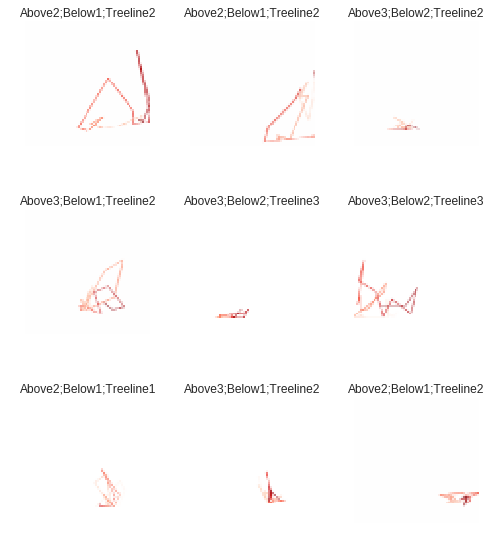

In [50]:
#view data

folders = ['1','2','3','4']
classes = folders
path = Path('/content/drive/My Drive/Fastai/Images/Temp_Precip/All/') #path of image locations

#first, use lower resolution images -- will use higher resolution images later, starting low res speeds up training
np.random.seed(42)
data = ImageDataBunch.from_df(path, labelsdf, valid_pct=0.2,
        ds_tfms=get_transforms(do_flip=False), size=64, num_workers=4).normalize(imagenet_stats) #this arranges images/labels with all the info for the CNN

data.show_batch(rows=3, figsize=(7,8)) #visualize some images and their labels
print(data.classes, data.c, len(data.train_ds), len(data.valid_ds))

In [51]:
#train the model

acc_02 = partial(accuracy_thresh, thresh=0.2) #first metric: accuracy, where if the output node (corresponding to a class) exceeds a value of 'thresh', the image is given that classification
f_score = partial(fbeta, thresh=0.2) #fbeta metric, often used in kaggle

learn = create_cnn(data, models.resnet34,metrics=[acc_02,f_score]) #use resnet34
learn.fit_one_cycle(4) #run 4 epochs, updating only the weights of the final dense layer

learn.save('all' + '_stage-1') #save this model step

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.763249,0.589453,0.315854,0.628485,00:27
1,0.595225,0.472210,0.665436,0.662651,00:27
2,0.525933,0.467187,0.654111,0.668051,00:27
3,0.494115,0.464506,0.655835,0.678350,00:28


In [52]:
learn.unfreeze() #unfreeze all model layers to have their weights updated
learn.lr_find() #try to optimize learning rate
learn.recorder.plot() #plot loss vs learning rate; choose learning rate to be ~10x smaller than when the loss starts to increase

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [54]:
learn.fit_one_cycle(20,max_lr=slice(1e-4,1e-3)) #now run 20 epochs and see how it does

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.471489,0.449431,0.664697,0.693154,00:31
1,0.465530,0.438914,0.670606,0.700220,00:30
2,0.456862,0.426278,0.687715,0.710168,00:28
3,0.444632,0.427616,0.673806,0.715105,00:28
4,0.434766,0.413137,0.717750,0.723393,00:28
5,0.417696,0.419389,0.731167,0.712779,00:28
6,0.409382,0.407508,0.723289,0.719909,00:28
7,0.402195,0.376864,0.729690,0.755973,00:28
8,0.392536,0.375019,0.740030,0.755205,00:28
9,0.382019,0.366230,0.740645,0.763660,00:28


In [0]:
learn.save('all' + '_stage-2') #save at this point

In [57]:
#now, increase resolution and see if that helps
path = Path('/content/drive/My Drive/Fastai/Images/Temp_Precip/All')
data = ImageDataBunch.from_df(path, labelsdf, valid_pct=0.2,
        ds_tfms=get_transforms(do_flip=False), size=128, num_workers=4).normalize(imagenet_stats)

learn.data = data
learn.unfreeze()
learn.lr_find() #find new learning rate to use
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [59]:
learn.fit_one_cycle(20,max_lr=slice(1e-4,1e-3)) #run 20 more epochs

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.393220,0.346784,0.775603,0.770287,00:42
1,0.364420,0.320570,0.791851,0.797024,00:42
2,0.345591,0.347992,0.762925,0.770161,00:42
3,0.338372,0.353409,0.785328,0.772430,00:43
4,0.333390,0.343908,0.789882,0.784871,00:42
5,0.332606,0.356257,0.764156,0.769755,00:42
6,0.326008,0.335160,0.785943,0.787209,00:43
7,0.320283,0.363169,0.790620,0.773494,00:42
8,0.312242,0.351291,0.805391,0.792013,00:43
9,0.302875,0.338623,0.817947,0.787256,00:43


In [0]:
learn.save('all' + '_stage-3') #save this stage of model
